In [4]:
import os, importlib, sys, time, h5py

In [5]:
import numpy as np
from scipy import io, linalg, stats, ndimage, signal
from scipy.sparse import diags

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':12})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})
# rc('text', usetex=False)

In [7]:
import ladyns as ldn
import ladyns.inference as inf

In [9]:
save_dir = "../temp/Appendix_C1"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 1. simulate data

In [10]:
dims = [25, 25]
num_rtime = 500
num_trial = 1000
rec_time = [0, 500]

In [11]:
coords_S = [np.array(np.where(np.full((5,5), True))).T for _ in np.arange(2)]
sigmas_S = [0.8, 0.8]
covs_S = [np.exp(-np.sum((cd[:,None,:] - cd[None,:,:])**2,-1)
                 / (2 * sigma**2))
          for cd, sigma in zip(coords_S, sigmas_S)]

## background pink noise

In [12]:
alpha = 1.4
f = np.linspace(0, np.pi, num_rtime//2+1)[1:-1]
psd = 1/(f**alpha)

In [13]:
Ws = [np.sqrt(0.5 * psd)[:,None] * 
          np.random.multivariate_normal(np.zeros(d), cov, 
                size=(num_trial, num_rtime//2-1))
          for d, cov in zip(dims, covs_S)]
RZs = [np.concatenate([
       np.random.multivariate_normal(np.zeros(d), cov, 
           size=(num_trial,1)), 
       W, 
       np.random.multivariate_normal(np.zeros(d), cov, 
           size=(num_trial,1)), 
       np.flip(W, axis=1)], axis=1)
       for d, W, cov in zip(dims, Ws, covs_S)]

In [14]:
Ws = [np.sqrt(0.5 * psd)[:,None] * 
      np.random.multivariate_normal(np.zeros(d), cov, 
            size=(num_trial, num_rtime//2-1))
      for d, cov in zip(dims, covs_S)]
IZs = [np.concatenate([
       np.zeros((num_trial,1,d)), 
       W, 
       np.zeros((num_trial,1,d)), 
       np.flip(W, axis=1)], axis=1)
       for W, cov, d in zip(Ws, covs_S, dims)]

In [15]:
etas = [np.fft.irfft(RZ+ 1j*IZ, num_rtime, axis=1)
        + 1j * np.fft.irfft(RZ+ 1j*IZ, num_rtime, axis=1)
        for RZ, IZ in zip(RZs, IZs)]

## beta band signal

In [18]:
num_blobs = 3

In [19]:
f_beta = 18
cwt_omega = 3
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)
filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)

In [20]:
ts_sig = [80, 200, 400]
ss_sig = [1250, 1250, 1250]
pbts = [np.exp(-np.square(np.arange(num_rtime) - t)/s)
       for t, s in zip(ts_sig, ss_sig)]

In [21]:
cwt_omega = 3
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)
filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)

In [22]:
Ws = [np.random.normal(scale=pbt, size=(num_trial,num_rtime))
      for pbt in pbts]
sigs =  [signal.convolve(W, filter_map[None,:])
         for W in Ws]

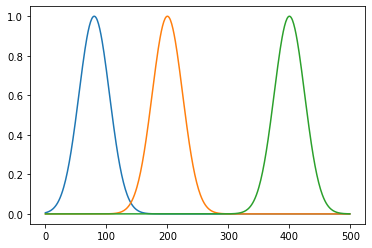

In [23]:
plt.plot(pbts[0])
plt.plot(pbts[1])
plt.plot(pbts[2])

/home/hbong/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


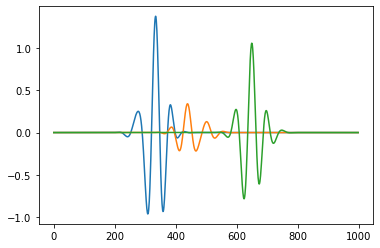

In [24]:
plt.plot(sigs[0][1])
plt.plot(sigs[1][1])
plt.plot(sigs[2][1])

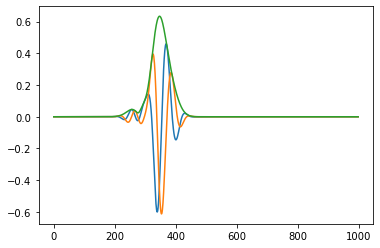

In [25]:
plt.plot(np.real(sigs[0][0]))
plt.plot(np.imag(sigs[0][0]))
plt.plot(np.abs(sigs[0][0]))

## observation

In [26]:
lags = [[0, 30, 30],
        [30, 0, 0]]
w = 0.08

In [27]:
ctrs = [[(1, 1), (3, 3), (2, 2)],
        [(3, 3), (1, 1), (2, 2)]]

In [28]:
betas = [[np.exp(-np.sum((cd-ct)**2,-1)/(2*sig**2))
          for ct in ctr]
         for cd, ctr, sig in zip(coords_S, ctrs, sigmas_S)] 

In [29]:
obss = [eta + np.exp(2j*np.pi*np.random.uniform(size=1000)[:,None,None]) * w * beta[0] * sigs[0][:,num_rtime//2-lag[0]:-num_rtime//2-lag[0]+1,None]
            + np.exp(2j*np.pi*np.random.uniform(size=1000)[:,None,None]) * w * beta[1] * sigs[1][:,num_rtime//2-lag[1]:-num_rtime//2-lag[1]+1,None]
            + np.exp(2j*np.pi*np.random.uniform(size=1000)[:,None,None]) * w * beta[2] * sigs[2][:,num_rtime//2-lag[2]:-num_rtime//2-lag[2]+1,None]
        for eta, beta, lag in zip(etas, betas, lags)]

## true factor loadings

In [30]:
fpbts = [
    signal.convolve(pbt, np.abs(signal.convolve(filter_map, filter_map, mode='same')))
    for pbt in pbts
]
betas_true = np.array([
    beta[0] * fpbts[0][num_rtime//2-lag[0]:-num_rtime//2-lag[0]+1:10,None]
    + beta[1] * fpbts[1][num_rtime//2-lag[1]:-num_rtime//2-lag[1]+1:10,None]
    + beta[2] * fpbts[2][num_rtime//2-lag[2]:-num_rtime//2-lag[2]+1:10,None]
    for beta, lag in zip(betas, lags)
])

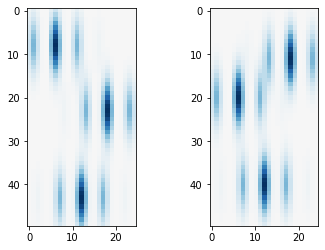

In [31]:
plt.subplot(1,2,1); ldn.imshow(betas_true[0])
plt.subplot(1,2,2); ldn.imshow(betas_true[1])

# 2. pre-processing

In [32]:
num_time = num_rtime//10

In [33]:
cwt_omega = 3 
cwt_scale = cwt_omega * 1000 / (2 * f_beta * np.pi)
filter_map = signal.morlet2(num_rtime, cwt_scale, cwt_omega)

In [34]:
data = [np.zeros((num_time, d , num_trial), dtype=np.cdouble)
        for d in dims]

In [35]:
for l, d in enumerate(dims):
    for i in np.arange(d):
        data[l][:,i,:] = (signal.convolve(obss[l][:,:,i], 
            filter_map[None,:], mode='same')[:,::10]).T

In [38]:
Sigma_true = np.corrcoef(np.concatenate([ np.squeeze(
    btrue[:,None,:] 
    @ np.array([np.linalg.inv(np.cov(d)) for d in np.abs(dat)])
    @ np.abs(dat)) for dat, btrue in zip(data, betas_true)], 0))

Omega_true = np.linalg.inv(Sigma_true + lambda_diag * np.eye(2*num_time))

Coh_true = np.abs(np.corrcoef(np.concatenate([ np.squeeze(
    btrue[:,None,:] 
    @ np.array([np.linalg.inv(np.cov(d)) for d in np.abs(dat)])
    @ dat) for dat, btrue in zip(data, betas_true)])))

## plots

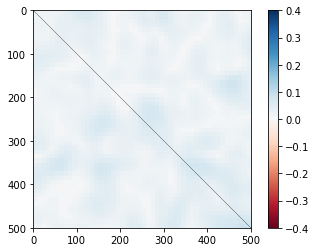

In [39]:
ldn.imshow(Coh_true[:num_time,num_time:], time=rec_time, identity=True, vmax=0.4)
plt.colorbar()

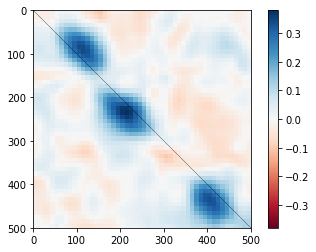

In [40]:
ldn.imshow(Sigma_true[:num_time,num_time:], time=rec_time, identity=True)
plt.colorbar()

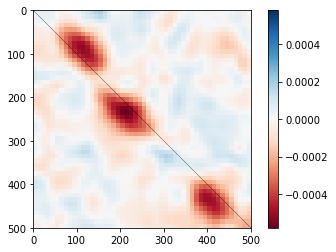

In [41]:
ldn.imshow(Omega_true[:num_time,num_time:], time=rec_time, identity=True)
plt.colorbar()

# 3. LaDynS

In [36]:
offset_cross = 10
offset_auto = 10

In [37]:
lambda_cross, lambda_auto, lambda_diag = 0.1, 0.0, 20

In [42]:
Omega_est, Sigma_est, latent_est, weight_est =\
    ldn.fit([np.abs(data[0]),np.abs(data[1])], 
            lambda_diag, lambda_cross, offset_cross,
            lambda_auto, offset_auto, 
            ths_glasso=1e-6, ths_lasso=1e-6, verbose=True)

1-th iter, nll: 404.086082, change: 0.215964, lapse: 0.231158
2-th iter, nll: 404.072855, change: 0.073997, lapse: 0.198077
3-th iter, nll: 404.059278, change: 0.072953, lapse: 0.221109
4-th iter, nll: 404.046607, change: 0.078231, lapse: 0.197649
5-th iter, nll: 404.036591, change: 0.067241, lapse: 0.123776
6-th iter, nll: 404.029712, change: 0.047375, lapse: 0.156403
7-th iter, nll: 404.025276, change: 0.032319, lapse: 0.165118
8-th iter, nll: 404.022398, change: 0.022123, lapse: 0.133588
9-th iter, nll: 404.020467, change: 0.014822, lapse: 0.128798
10-th iter, nll: 404.019125, change: 0.010908, lapse: 0.189652
11-th iter, nll: 404.018168, change: 0.009057, lapse: 0.109025
12-th iter, nll: 404.017470, change: 0.007170, lapse: 0.106910
13-th iter, nll: 404.016955, change: 0.005539, lapse: 0.107591
14-th iter, nll: 404.016570, change: 0.005298, lapse: 0.106389
15-th iter, nll: 404.016279, change: 0.004912, lapse: 0.107113
16-th iter, nll: 404.016058, change: 0.004447, lapse: 0.105562
1

## plots

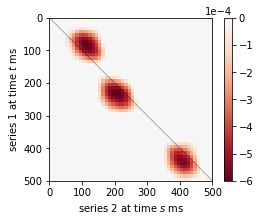

In [46]:
plt.figure(figsize=(4,3))
ldn.imshow(Omega_est[:num_time,num_time:], vmax=0.0006, identity=True, time=[0,500])
plt.xlabel(r"series 2 at time $s$ ms"); plt.ylabel(r"series 1 at time $t$ ms")
cbar = plt.colorbar()
cbar.ax.set_ylim(-6e-4,0); cbar.formatter.set_powerlimits((0, 0))